PCA, scaling and clustering.
-----

**Principal component analysis** (PCA) is a tool to find the directions in a dataset that have the largest variance.
One application of this is finding a lower-dimensional representation of the data that retains as much of the data's variation as possible.
This makes exploring the data much more tractable.

However, the directions with the largest variance are not necesssarily the directions that contain the information we need to really understand the data.
For example, it is possible that the information that distinguishes between **clusters** in the data is contained in components that only explain a small fraction of the variance.

In this notebook I am using PCA, scaling, and clustering, to gain a little intuition about how those concepts interact. More specifically, this notebook will construct a simple two-dimensional example where the information that actually distinguishes between clusters is contained in the dimension with the least variance.

**What will we learn from this?** We'll see the importance of standardising the data, and the importance of not relying entirely on approximating the data by its principal components if one is interested in clusters.
While this example is overly simple, the lesson is worth keeping in mind for problems involving higher dimensional data, such as image classification.

In [1]:
import numpy as np
import scipy as sp
import sklearn as sk
import matplotlib.pyplot as plt
from numpy.random import multivariate_normal, default_rng
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture

In [2]:
mean1 = [0.2, 1]
mean2 = [-0.2, 1]
mean3 = [0, 1]
means = [mean1, mean2, mean3]
covs1  = [[0.001, 0],[0, 0.2]]
covs2  = [[0.001, 0],[0, 0.2]]
covs3  = [[0.001, 0],[0, 2.0]]
covs = [covs1, covs2, covs3]

In [3]:
N_sample = 1000
rng = default_rng(42)
samples = []
for av, cov in zip(means, covs):
    samples += list(rng.multivariate_normal(av, cov, size=N_sample))
samples = np.array(samples)

We'll generate data from two 2D Gaussian clusters, separated in one dimension, with a small enough variance in that direction that they don't significantly overlap. We'll give them a large variance in the other direction. We will draw 1000 samples from each cluster, for a total of 2000.

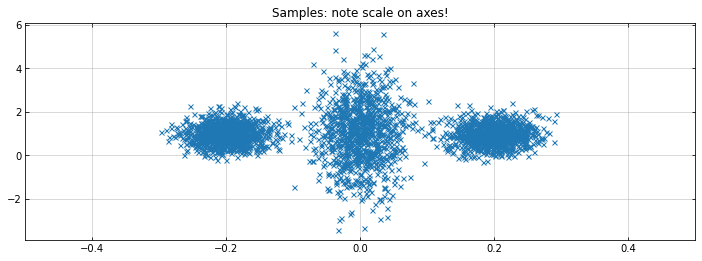

In [4]:
fig, ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(samples[:,0], samples[:,1], 'x')
#ax.axis('scaled')
plt.title('Samples: note scale on axes!')
plt.xlim([-0.5, 0.5])
plt.show()

In [5]:
n_components = 2
## # Scaling and PCA
pca1 = PCA(n_components=n_components, random_state=42)
scl_pca_pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca1)])
## # Just scaling
scl_pipe = Pipeline([('scaler', StandardScaler())])
## # Just PCA
pca2 = PCA(n_components=n_components, random_state=42)
pca_pipe = Pipeline([('pca', pca2)])

pipes = [scl_pca_pipe, scl_pipe, pca_pipe]
pipe_desc = ['Scaling and PCA', 'Scaling, no PCA', 'PCA, no scaling (note scale on axes!)']
for pipe in pipes:
    pipe.fit(samples)

We'll process this data in three independent pipelines. We will:
1. Standardise the data and then use PCA.
2. Just standardise the data.
3. Just use PCA.

Using a Gaussian mixture model (GMM) we will find clusters in the data, using both dimensions.
We will then plot the distribution in two ways. First, with respect to just the first component (a histogram), and then with respect to both components (a scatter plot). In both cases we will colour the plot using the cluster labels that were found from the full two dimensional data. The goal is to see **how much cluster information is contained in the leading component** of each pipeline, and how the scaling affects the results of the GMM.

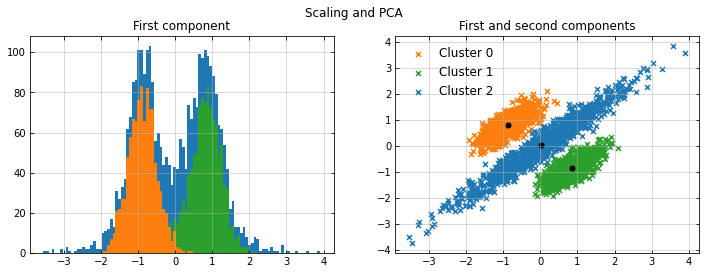

PCA directions:
 [[-0.70710678  0.70710678]
 [ 0.70710678  0.70710678]]


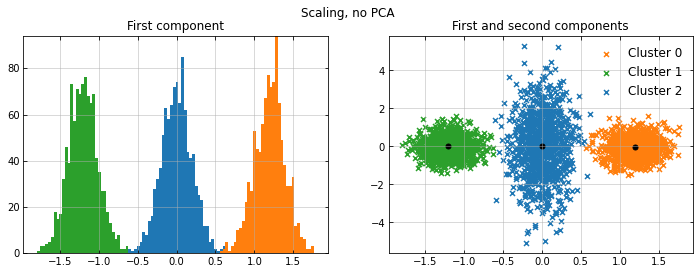

No PCA, so just [[1,0],[0,1]].


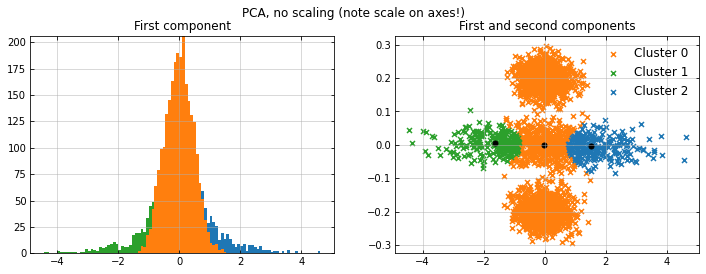

PCA directions:
 [[-0.0027733   0.99999615]
 [-0.99999615 -0.0027733 ]]


In [6]:
for pipe, desc in zip(pipes, pipe_desc):
    samples_trans = pipe.transform(samples).T
    #centers = pipe.transform(np.array(means))
    clusters_2d = GaussianMixture(n_components=len(means), random_state=42, tol=1e-4).fit(samples_trans.T)
    labels_2d = clusters_2d.predict(samples_trans.T)
    unique_labels = set(labels_2d)
    colors = dict(zip(unique_labels, ["tab:orange","tab:green",'tab:blue']))

    fig, axs = plt.subplots(1,2,figsize=(12,4))
    axs[0].set_title('First component')
    axs[0].hist([samples_trans[0][labels_2d==l] for l in unique_labels], bins=100, color=[colors[l] for l in unique_labels], stacked=True)
    axs[1].set_title('First and second components')
    for l in unique_labels:
        axs[1].scatter(samples_trans[0][labels_2d==l], samples_trans[1][labels_2d==l], marker='x', c=colors[l], label=f'Cluster {l}')
    axs[1].scatter(clusters_2d.means_[:,0], clusters_2d.means_[:,1], marker='o', color='k')
    #axs[1].axis('scaled')
    suptitle = desc
    fig.suptitle(suptitle)
    axs[1].legend()
    plt.show()
    try:
        eigvecs = pipe['pca'].components_
        print('PCA directions:\n',eigvecs)
    except:
        print('No PCA, so just [[1,0],[0,1]].')

Conclusions
------
When PCA is applied to the scaled data, the principal component hints at the cluster structure, through the
bimodality of the histogram.
The GMM also finds the expected clusters in the scaled data.

Scaling the data, but not applying PCA, means the first dimension contains no cluster information (which is, of course, by design).
We see however that the GMM does manage to find the correct clusters.

When PCA is applied to the unscaled data it finds the principal component to be almost identical to the initial x-direction, which contains no information about the clusters, so we see no hint of the cluster structure in the histogram.
Additionally, applying the GMM to the two-dimensional data does not give the cluster results we wanted, again due to the lack of scaling.

Scaling is obviously pretty important!
The problem of how dimensional reduction interacts with clustering is a little trickier, however.
The solution in this example is clear - the PCA is not needed in the first place,
since the dimension of the data is so low.
But there is a more general lesson to learn here: when reducing the dimensionality of a dataset, we must take care not to blindly optimise for explained variance. PCA can be a powerful tool, but there are cases that lead it astray.